# CS6140 Machine Learning: Assignment 4 (F22) (Total Points: 100)
## Prof. Ahmad Uzair


## 2. PCA understanding [10 pts]

#### 1. Write your understanding of PCA. 
Principal Component Analysis (PCA) is the process of removing the correlation between features in the dataset and removing as many features as possible while preserving the information of the dataset. Smaller datasets (less features) are easier (less complex, less resources) to analyze and model and PCA helps by removing extraneous variables to reduce the dataset size. The outcome of PCA is an ordered list of features - the order corresponds to the amount of information each variable/feature contributes to the dataset.

#### 2. Why is it needed? 
PCA is needed to reduce the size/complexity of the dataset which thereby speeds up machine learning calculations and reduces model complexity while preserviing the information (trends, patterns, etc.). 

#### 3. How does it works? 
PCA decorelates the features and then calculates how much variance each feature contributes to the dataset. The feature that accounts for the most variance in the dataset is the first principal component, the second is 2nd, and so on. This is done by first standardizing the range of continuous variables, then computing the cavariance matrix (correlations), then computing eigen vectors and eigenvalues to identify the principal components so that we can extract a feature vector to use for recasting the dataset for modelling.

#### 4. How does it helps ?
PCA can identify features that contribute little information to the dataset and can be discarded for modelling - thereby simplifying the analysis and model. This is useful to gain a better understanding of the dataset and which features are contributing vs. not.

#### 5. Think of and give an example scenario where it is useful and can be used.
Take for example predicting the test performance of high school students by school. You are given a dataset of test scores (labels) for each school with 100 features about the school - for example: household income, single parent rate, school funding, median home price, % reduced lunch, absense rate, special needs rate, etc. Principal Component Analysis may uncover that only 20 out of the 100 features are truly significant and the other 80 features can be ignored for modelling because they are highly correlated with the 20 features which contribute information. This insight would significantly reduce the size of such a model.

## 2. Coding Exercise [30 pts]

** Note : Read The Whole Question For Better Understanding Of The Demand Of The Exercise.**

Read the given csv file ('airbnb.csv')

### 1. [Feature elimination] : Carefully look and understad the nature of the data, remove potentially unnecessary/less useful features. [2 pts]

[Hint: After elimination you should be left with 8-10 features]



In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Ready data
_data = pd.read_csv('airbnb.csv')

# Describe initial dataset
print(_data.describe())
print(_data.head())

                 id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.00

In [201]:
# Split out price as the label
y = _data['price']

# Drop the columns that won't be used for model
data = _data.drop(['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude', 'last_review', 'price'], axis=1)
print("Features to be used in model:")
print(list(data.columns))


Features to be used in model:
['neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


### 2. Data conversion
Select appropriate text features and suitably convert them into numerical features. [5 pts]



In [203]:
# Convert the features that are text into numerical
import sklearn.preprocessing as pre
from pandas.api.types import is_string_dtype
le = pre.LabelEncoder()
le.fit(data['room_type'])

# X is a pandas df
def transformTextFeatures(X):
    op = X.copy()
    le = pre.LabelEncoder()
    for col in list(X.columns):
        if is_string_dtype(X[col]):
            le.fit(X[col])
            op[col] = le.transform(X[col])
    return op

X = transformTextFeatures(data)

# Print transformed data
print(X.head())


   neighbourhood_group  neighbourhood  room_type  minimum_nights  \
0                    1            108          1               1   
1                    2            127          0               1   
2                    2             94          1               3   
3                    1             41          0               1   
4                    2             61          0              10   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                  9               0.21                               6   
1                 45               0.38                               2   
2                  0                NaN                               1   
3                270               4.64                               1   
4                  9               0.10                               1   

   availability_365  
0               365  
1               355  
2               365  
3               194  
4                 0  


In [204]:
# Check for blanks 
nanCols = list(np.unique(np.where(pd.isnull(X))[1]))
print("Cols with blanks:", list(X.columns[nanCols]))

Cols with blanks: ['reviews_per_month']


In [205]:
# Replace blanks with 0s
X = X.fillna(0)

# Check for blanks again
nanCols = list(np.unique(np.where(pd.isnull(X))[1]))
print("Cols with blanks:", list(X.columns[nanCols]))

Cols with blanks: []


### 3. Model Training:
Train a linear regression model over the entire data.  [5 pts]

[Note 1: A library can be used, Target variable is 'price', Use all features.]

[Note 2: Report and maintain accuracy and time taken to train the model]



In [209]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import time, math

# Scale the data
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

# Function to print training time and R-squared accuracy of model
def getResults(X, y):
    # Split data between training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Get time to train model
    start = time.time()
    model = LinearRegression().fit(X_train, y_train)
    stop = time.time()
    secs = stop - start
    
    # Get the MSE
    y_pred = model.predict(X_test)
    mse = math.sqrt(mean_squared_error(y_test, y_pred))

    return secs, mse


results_prePCA = getResults(X, y)
print("Time =", round(results_prePCA[0], 4))
print("MSE =", round(results_prePCA[1],4))

Time = 0.0126
MSE = 212.4957


### 4. Apply PCA: 
Use PCA to reduce dimensions to N = 5, 4, 3, 2, 1. Using these new features, train the a new model again. [10 pts.]

[Note 3: A library can be used for PCA, Target variable is still 'price', Use 'N' features at a time for a model.]

[Note 4: Report and maintain accuracy and time taken to train each the model and also the time taken for PCA for each 'N' value.]




In [212]:
from sklearn.decomposition import PCA


# 5 rows (for each N) and 3 columns -> 0: time, 1: MSE, 2: accruacy
components = [5,4,3,2,1]
results = np.zeros([len(components), 2])
for c in range(len(components)):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Apply PCA
    pca = PCA(n_components=components[c])
    X_t = pca.fit_transform(X_train)
    
    # Get time to fit
    start = time.time()
    model = LinearRegression().fit(X_train, y_train)
    stop = time.time()
    t = stop - start # time to fit
    
    # Get MSE
    y_pred = model.predict(X_test)
    mse = math.sqrt(mean_squared_error(y_test, y_pred))
    

    # Add to results
    results[c] = np.array([t, mse])

In [214]:
print("Array of [time, MSE] for [5,4,3,2,1] components")
print(results)

Array of [time, MSE] for [5,4,3,2,1] components
[[1.65119171e-02 2.19861986e+02]
 [1.46021843e-02 2.07256370e+02]
 [9.81402397e-03 1.79154924e+02]
 [1.24502182e-02 2.22623629e+02]
 [1.30531788e-02 2.77210329e+02]]


### 5. Visualisation 
[6 pts]
5.1 Plot a graph, for number of features vs accuracy [Total 1+5 plots]. [2 pts]
5.2 Plot a graph, for time spend on training models [excluding the PCA time] vs accuracy [Total 1+5 plots]. [2 pts]

5.3 Plot a graph, for time spend on training models [including the PCA time] vs accuracy [Total 1+5 plots]. [2 pts]

[Note 5] : Since each sub part have 6 plots, try to make a 2x3 or 3x2 type of plot, so that 'glance' is possible.




Text(0.5, 1.0, 'Num Features vs. Accuracy (MSE)')

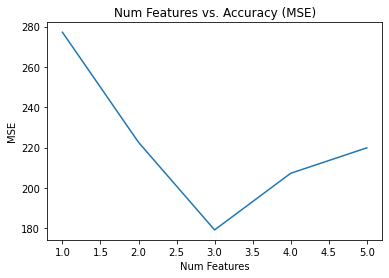

In [244]:
# 5.1 Features vs. Accuracy (MSE)
from importlib import reload
plt=reload(plt)
mse = pd.DataFrame(results[:,1].reshape(1,-1), columns=components).T
plt.ylabel("MSE")
plt.plot(mse)
plt.xlabel("Num Features")
plt.title("Num Features vs. Accuracy (MSE)")




Text(0.5, 1.0, 'Time vs Accuracy - before PCA')

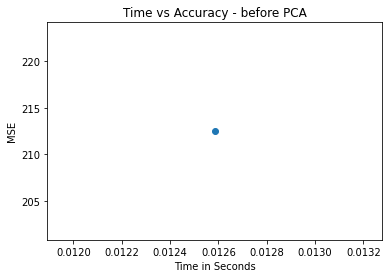

In [245]:
# 5.2 Plot the time spent training model vs accuracy (MSE) exlucding PCA
plt = reload(plt)
plt.scatter(x=results_prePCA[0], y=results_prePCA[1])
plt.xlabel("Time in Seconds")
plt.ylabel("MSE")
plt.title("Time vs Accuracy - before PCA")


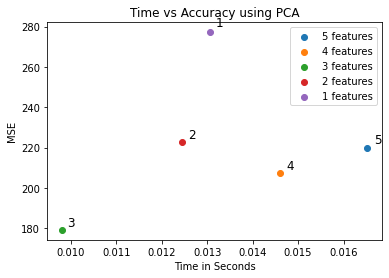

In [251]:
# 5.3: Times spent training model vs Accruacy using PCA
# Scatter plot - each dot will represent a different num components
plt = reload(plt)
plt.xlabel("Time in Seconds")
plt.ylabel("MSE")
plt.title("Time vs Accuracy using PCA")
cMap = {0:5, 1:4, 2:3, 3:2, 4:1}
for i in range(5):
    plt.scatter(x=results[i,0], y=results[i,1])
    plt.text(results[i,0]*1.01, results[i,1]*1.01, cMap[i], fontsize=12)
plt.legend([str(x) + " features" for x in components])

### 6. Analyze 
Have a look on the created plots, what do you think about the effectiveness of PCA in this practical application? Write your opinion with supportive arguments. [2 pts]

Using Principle Component Analysis was effective in this application. We started with 8 features which took 12.6 ms to train the model and yeilded a mean square error (MSE) of 212.5. However after applying principle component analysis, we were able to achieve a MSE of 179.2 and a training time of 9.8 ms when using just 3 of the features. This is a more time efficient result with a lower error. Therefore, using PCA was certaintly effective.